In [1]:
library(tidyverse)
library(arrow)
library(cowplot)
library(ggpubr)
library(duckplyr)
library(scattermore)
library(yardstick)
library(latex2exp)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggpubr’


The following ob

# Format for comparison

In [9]:
duckplyr_df_from_parquet("data/gwas/full_results.parquet") |> 
    filter(path |> str_detect("and|or|mul")) |>
    mutate(
        k = path |> str_extract("(?<=anon_)([0-9]{3})(?=_)") |> as.integer() |> replace_na(0),
        phenotype = path |> str_extract("(and|or|mul).+")
    ) |>
    select(phenotype, k, ID, BETA, SE, CHISQ) |>
    pivot_longer(c(BETA, SE, CHISQ), names_to = "sumstat", values_to = "sumstat_value") |>
    pivot_wider(names_from = k, values_from = sumstat_value) |>
    rename(exact = `0`) |>
    pivot_longer(c(`1`, `5`, `10`, `15`, `20`, `50`, `100`), names_to = "k", values_to = "approx") |>
    mutate(operator = phenotype |> str_extract("and|or|mul")) |>
    df_to_parquet("data/gwas-comparison.parquet")

duckplyr: materializing
duckplyr: materializing


NULL

# Compare direct vs indirect

In [10]:
duckplyr_df_from_parquet("data/gwas-comparison.parquet") |> 
    filter(sumstat == "CHISQ") |>
    group_by(operator, sumstat, k) |>
    summarize(rsq = rsq_vec(exact, approx), .groups = "drop")

duckplyr: materializing


operator,sumstat,k,rsq
<chr>,<chr>,<chr>,<dbl>
and,CHISQ,1,0.010284921
and,CHISQ,10,0.008185613
and,CHISQ,100,0.004493041
and,CHISQ,15,0.007432000
and,CHISQ,20,0.007102872
and,CHISQ,5,0.009038024
and,CHISQ,50,0.005848621
mul,CHISQ,1,0.007952186
mul,CHISQ,10,0.005707410


# Compare anonymized vs non-anonymized indirect

In [11]:
duckplyr_df_from_parquet("data/gwas-comparison.parquet") |> 
    filter(sumstat == "CHISQ") |>
    select(-exact) |>
    pivot_wider(names_from = k, values_from = approx) |>
    rename(de_anon = `1`) |>
    pivot_longer(c(`5`, `10`, `15`, `20`, `50`, `100`), names_to = "k", values_to = "anon") |>
    group_by(operator, sumstat, k) |>
    summarize(rsq = rsq_vec(de_anon, anon), .groups = "drop")

duckplyr: materializing


operator,sumstat,k,rsq
<chr>,<chr>,<chr>,<dbl>
and,CHISQ,10,0.5562439
and,CHISQ,100,0.2381207
and,CHISQ,15,0.5054703
and,CHISQ,20,0.4662386
and,CHISQ,5,0.6644482
and,CHISQ,50,0.3479461
mul,CHISQ,10,0.5647208
mul,CHISQ,100,0.1928377
mul,CHISQ,15,0.5060698


# Direct comparison of GWAS summary statistics

Warning message:
“Removed 210000 rows containing missing values or values outside the scale range (`geom_scattermore()`).”


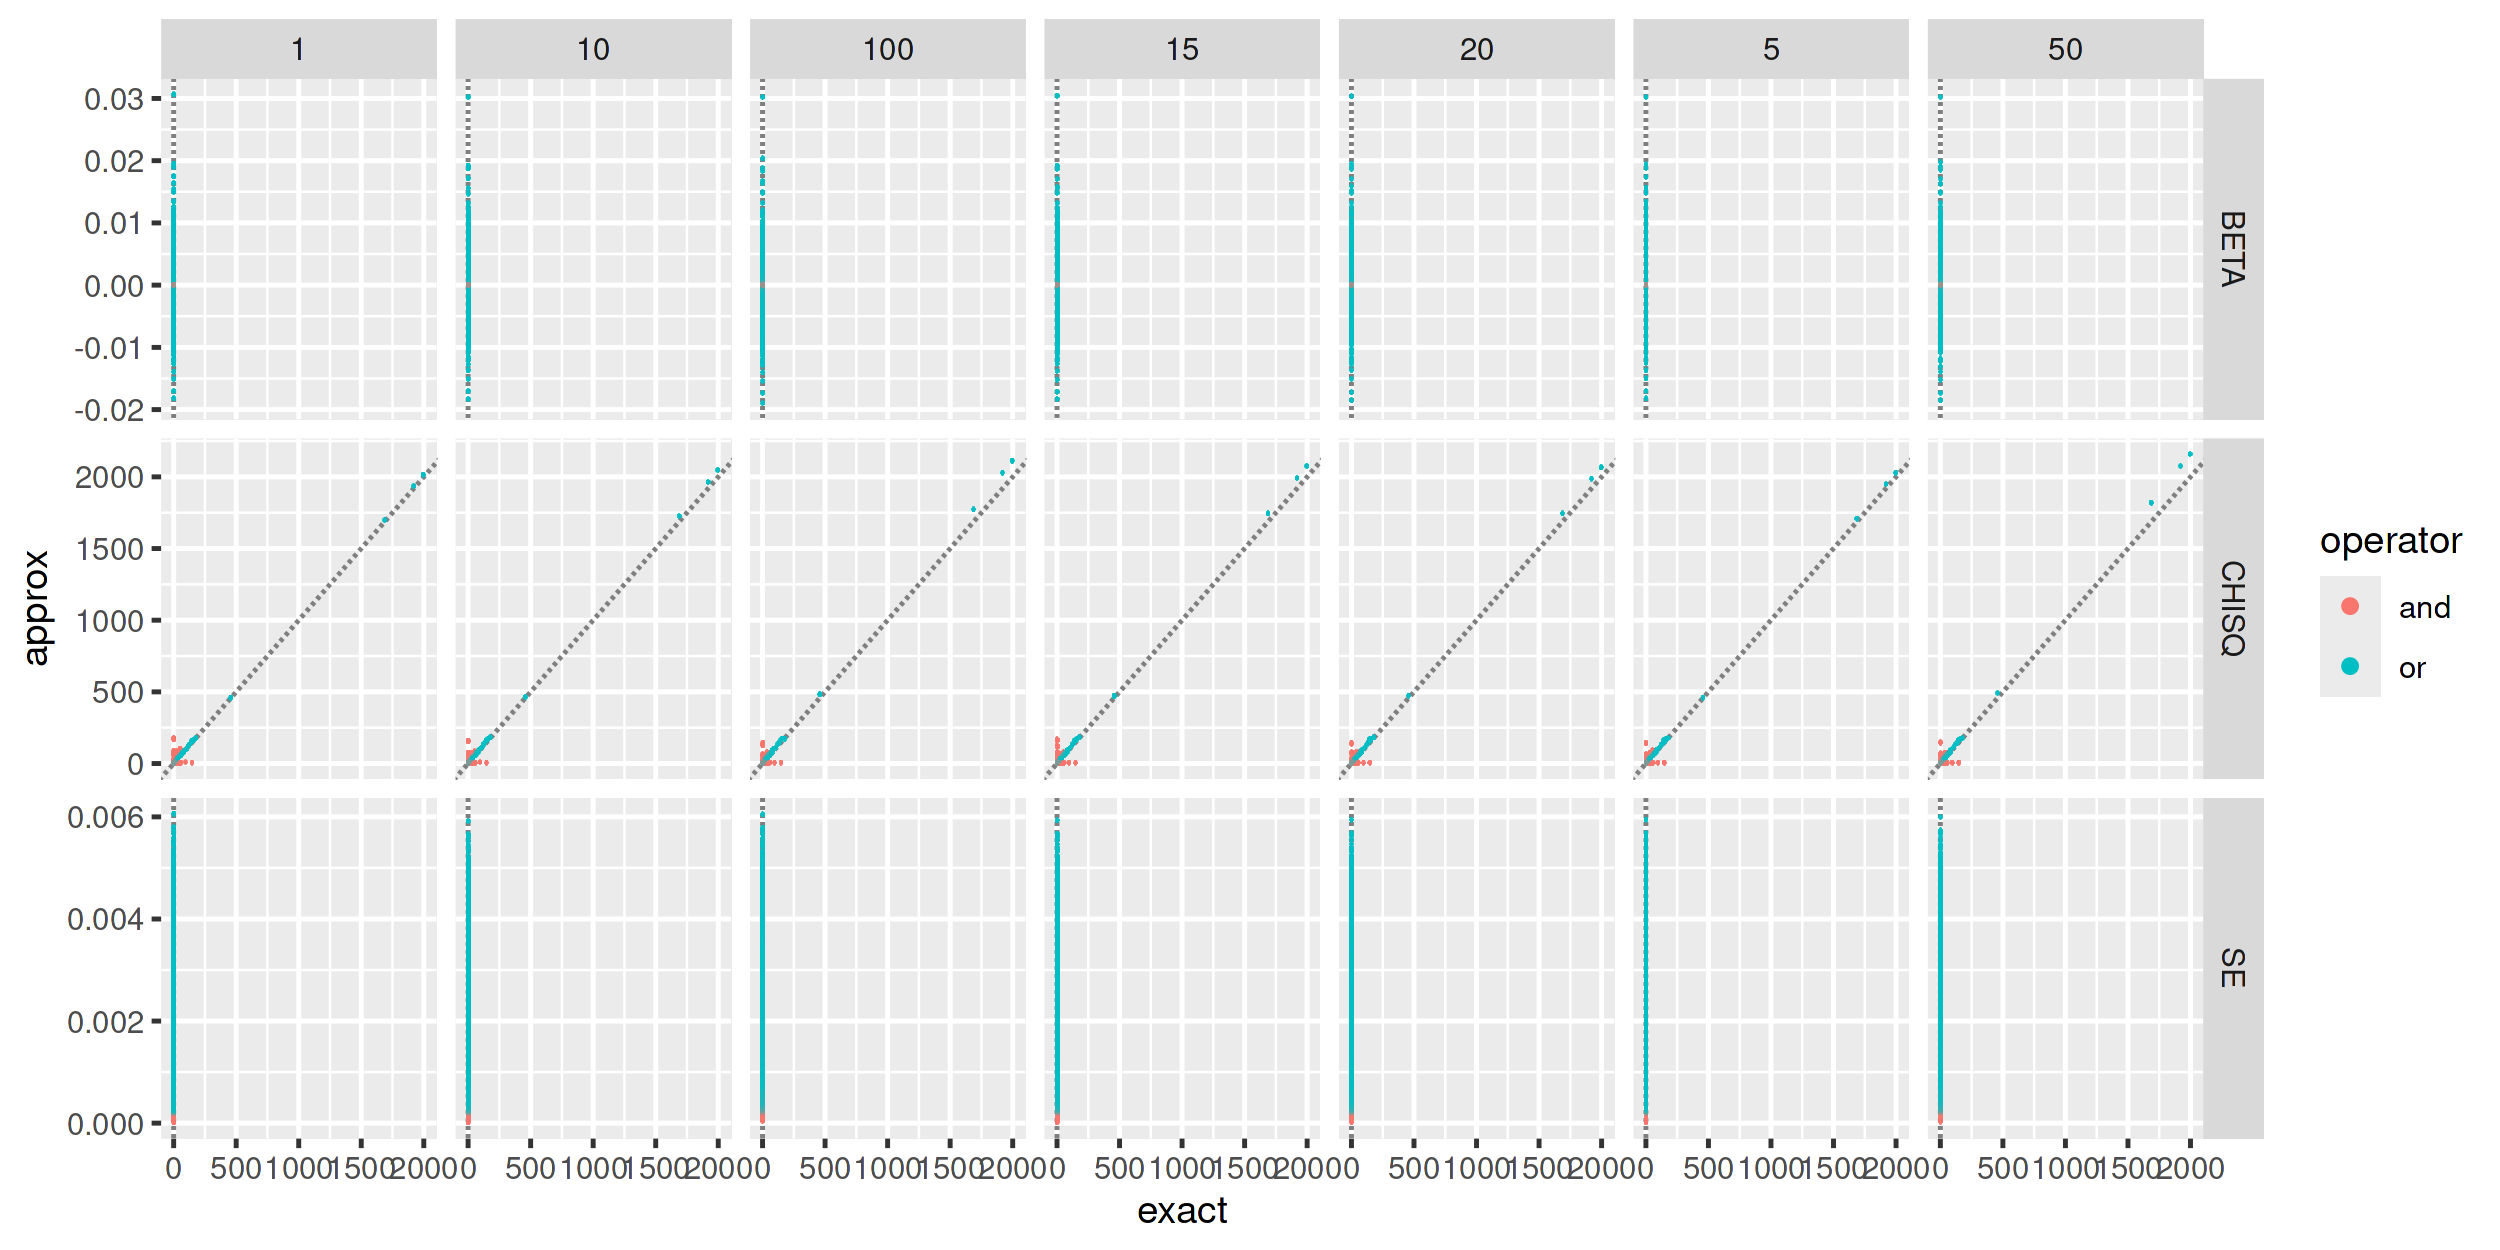

In [92]:
options(repr.plot.height = 5, repr.plot.width = 10, repr.plot.res = 250)

read_parquet("data/gwas-comparison.parquet") |>
    ggplot(aes(x = exact, y = approx, color = operator)) +
    geom_abline(slope = 1, intercept = 0, color = "gray50", linetype = "dashed") +
    geom_scattermore(pointsize = 5) +
    facet_grid(cols = vars(k), rows = vars(sumstat), scales = "free")

Warning message:
“Removed 30000 rows containing missing values or values outside the scale range (`geom_point()`).”


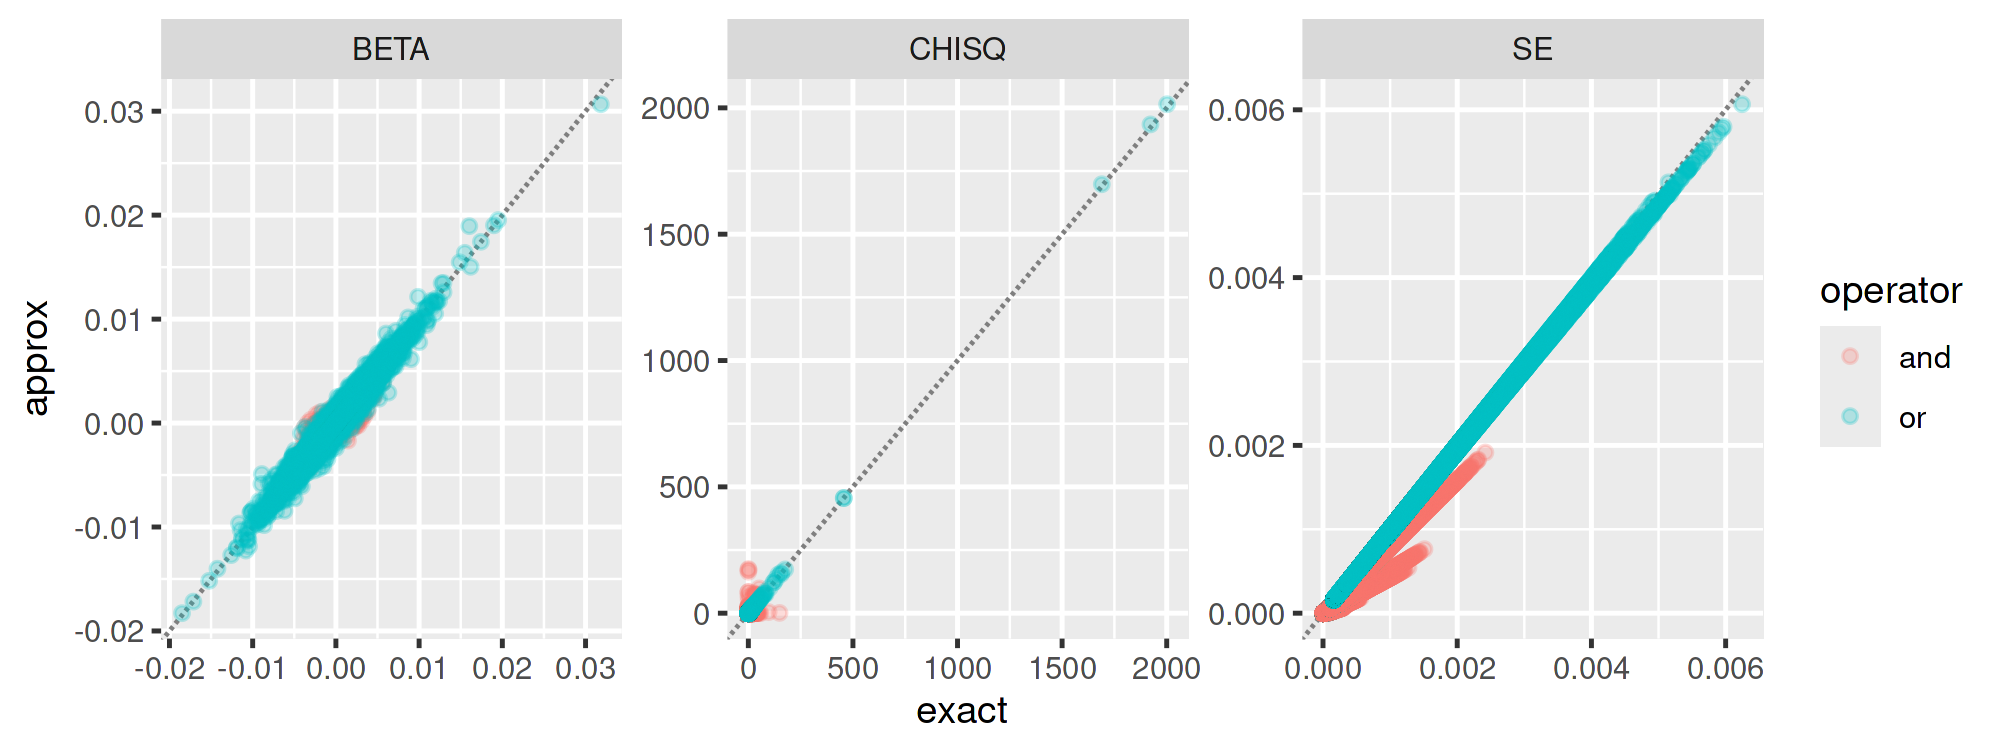

In [93]:
options(repr.plot.height = 3, repr.plot.width = 8, repr.plot.res = 250)

read_parquet("data/gwas-comparison.parquet") |>
    filter(k == 1) |>
    ggplot(aes(x = exact, y = approx, color = operator)) +
    geom_abline(slope = 1, intercept = 0, color = "gray50", linetype = "dashed") +
    geom_point(alpha = 0.25) +
    facet_wrap(vars(sumstat), scales = "free")

# Per-phenotype comparison

## Direct vs indirect

In [4]:
per_phenotype_vs_direct_df <- duckplyr_df_from_parquet("data/gwas-comparison.parquet") |> 
    filter(sumstat == "CHISQ") |>
    group_by(phenotype, operator, sumstat, k) |>
    summarize(rsq = rsq_vec(exact, approx), .groups = "drop")

per_phenotype_vs_direct_df |> head(2)

The duckplyr package is configured to fall back to dplyr when it encounters an incompatibility. Fallback events can be collected and uploaded for analysis
to guide future development. By default, no data will be collected or uploaded.
ℹ A fallback situation just occurred. The following information would have been recorded:
  {"version":"0.4.1","message":"No relational implementation for group_by()"}
→ Run `duckplyr::fallback_sitrep()` to review the current settings.
→ Run `Sys.setenv(DUCKPLYR_FALLBACK_COLLECT = 1)` to enable fallback logging, and `Sys.setenv(DUCKPLYR_FALLBACK_VERBOSE = TRUE)` in addition to enable
  printing of fallback situations to the console.
→ Run `duckplyr::fallback_review()` to review the available reports, and `duckplyr::fallback_upload()` to upload them.
ℹ See `?duckplyr::fallback()` for details.
ℹ This message will be displayed once every eight hours.


duckplyr: materializing


Warning message:
“There were 14 warnings in `summarize()`.
The first warning was:
ℹ In argument: `rsq = rsq_vec(exact, approx)`.
ℹ In group 232: `phenotype = "and_H15_F50"`, `operator = "and"`, `sumstat = "CHISQ"`, `k = "1"`.
Caused by warning:
! A correlation computation is required, but the inputs are size zero or one and the standard deviation cannot be computed. `NA` will be returned.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 13 remaining warnings.”


phenotype,operator,sumstat,k,rsq
<chr>,<chr>,<chr>,<chr>,<dbl>
and_B00_E16,and,CHISQ,1,0.002486292
and_B00_E16,and,CHISQ,10,0.001295141


Warning message:
“Removed 14 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range (`geom_point()`).”


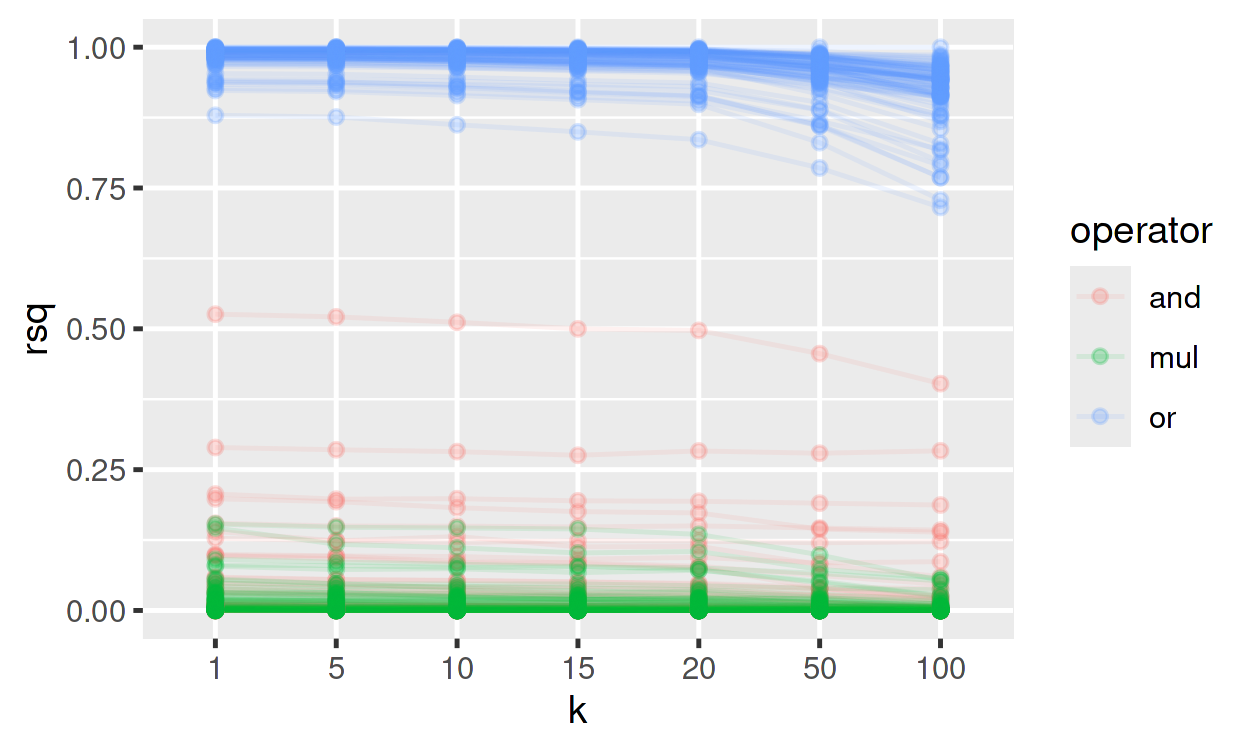

In [5]:
options(repr.plot.height = 3, repr.plot.width = 5, repr.plot.res = 250)

per_phenotype_vs_direct_df |>
    mutate(k = factor(k, levels = c("1", "5", "10", "15", "20", "50", "100"))) |>
    ggplot(aes(y = rsq, x = k, color = operator)) +
    geom_line(aes(group = phenotype), alpha = 0.1) +
    geom_point(alpha = 0.25)

## Anonymized vs non-anonymized

In [2]:
per_phenotype_vs_anon_df <- duckplyr_df_from_parquet("data/gwas-comparison.parquet") |> 
    filter(sumstat == "CHISQ") |>
    select(-exact) |>
    pivot_wider(names_from = k, values_from = approx) |>
    rename(de_anon = `1`) |>
    pivot_longer(c(-phenotype, -ID, -sumstat, -operator, -de_anon), names_to = "k", values_to = "anon") |>
    group_by(phenotype, operator, sumstat, k) |>
    summarize(rsq = rsq_vec(de_anon, anon), .groups = "drop")

per_phenotype_vs_anon_df |> head(2)

duckplyr: materializing


Warning message:
“There were 12 warnings in `summarize()`.
The first warning was:
ℹ In argument: `rsq = rsq_vec(de_anon, anon)`.
ℹ In group 199: `phenotype = "and_H15_F50"`, `operator = "and"`, `sumstat = "CHISQ"`, `k = "10"`.
Caused by warning:
! A correlation computation is required, but the inputs are size zero or one and the standard deviation cannot be computed. `NA` will be returned.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 11 remaining warnings.”


phenotype,operator,sumstat,k,rsq
<chr>,<chr>,<chr>,<chr>,<dbl>
and_B00_E16,and,CHISQ,10,0.5077256
and_B00_E16,and,CHISQ,100,0.1322200


Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”


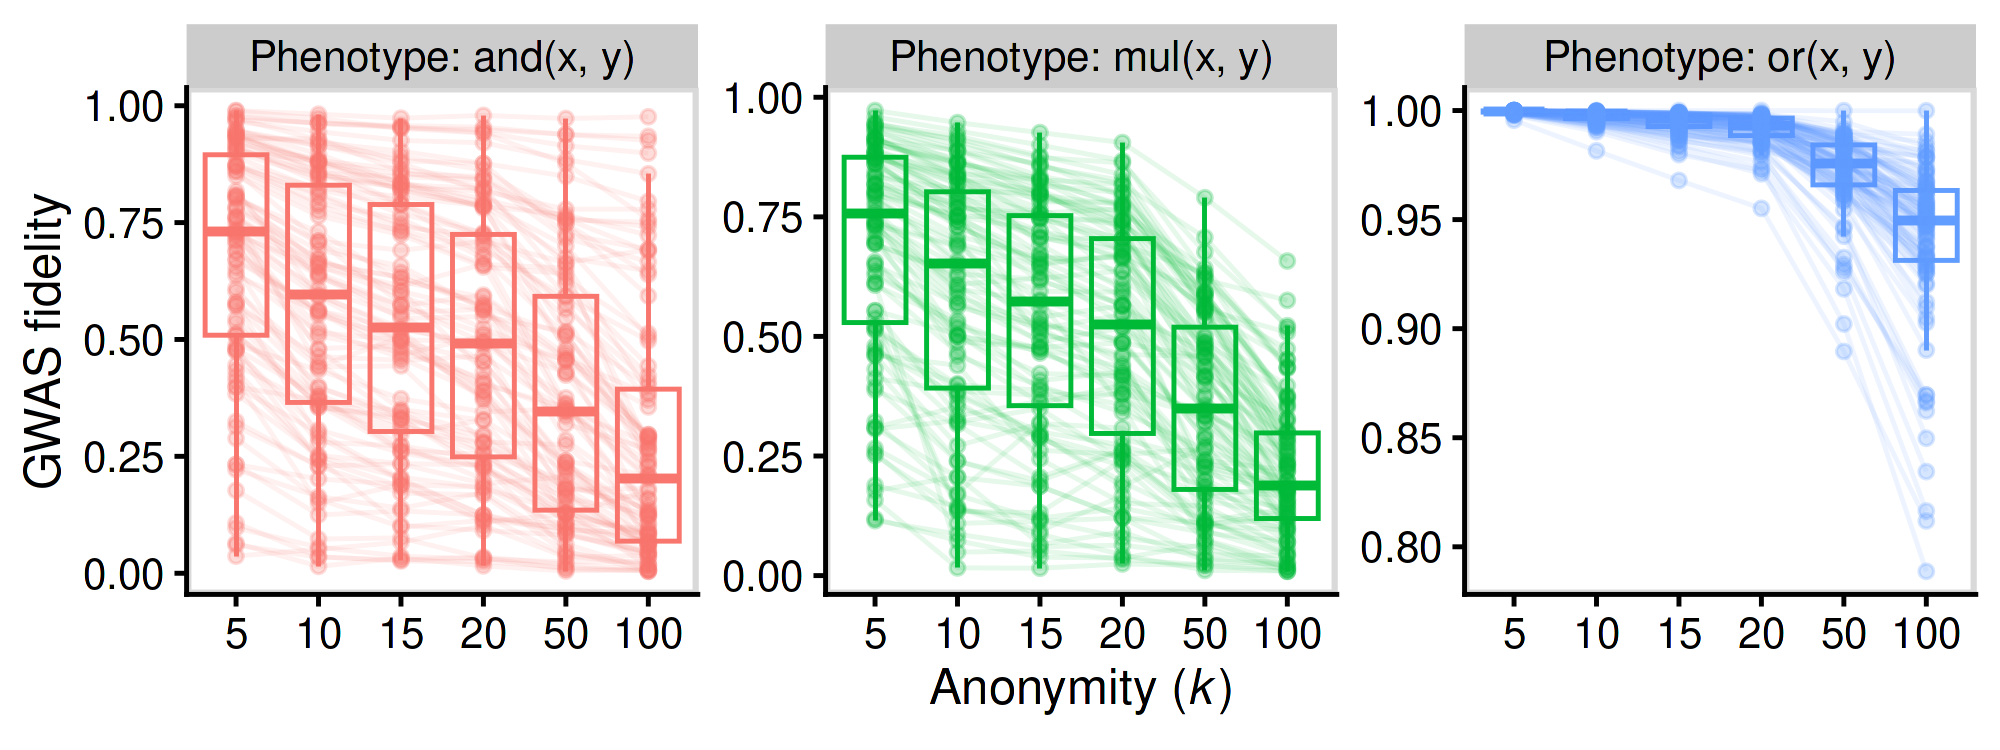

In [3]:
options(repr.plot.height = 3, repr.plot.width = 8, repr.plot.res = 250)

gwas_fidelity_plot <- per_phenotype_vs_anon_df |>
    mutate(k = factor(k, levels = c("5", "10", "15", "20", "50", "100"))) |>
    ggplot(aes(y = rsq, x = k, color = operator)) +
    geom_boxplot(aes(group = interaction(k, operator)), position = position_dodge(width = 1), outlier.shape = NA) +
    # geom_violin(aes(group = interaction(k, operator)), position = position_dodge(width = 1), scale = "width") +
    geom_line(aes(group = phenotype), alpha = 0.1) +
    geom_point(alpha = 0.25) +
    facet_wrap(vars(operator), scales = "free", labeller = labeller(operator = function(s) str_glue("Phenotype: {s}(x, y)"))) +
    theme_cowplot() +
    theme(legend.position = "none") +
    panel_border() +
    xlab(expression("Anonymity ("*italic(k)*")")) +
    ylab("GWAS fidelity")

gwas_fidelity_plot

# Equivalent plot for phenotypes

In [3]:
per_phenotype_fit_df <- duckplyr_df_from_csv("data/pheno/full_pheno.tsv") |>
    select(IID, matches("and|or|mul")) |>
    pivot_longer(-IID, names_to = "phenotype") |>
    mutate(
        operator = phenotype |> str_extract("and|or|mul"),
        k = phenotype |> str_extract("(?<=_)([0-9]{3})(?=_)") |> replace_na("direct"),
        phenotype = phenotype |> str_extract("(and|or|mul).+")
    ) |>
    pivot_wider(names_from = k, values_from = value) |>
    pivot_longer(c(-IID, -phenotype, -operator, -direct), names_to = "k", values_to = "indirect") |>
    group_by(phenotype, operator, k) |>
    summarize(
        n_distinct = n_distinct(direct),
        rsq = rsq_vec(direct, indirect, na_rm = TRUE),
        .groups = "drop"
    )

per_phenotype_fit_df |> write_parquet("data/phenotype-fit.parquet")

per_phenotype_fit_df |> head(2)

duckplyr: materializing


Warning message:
“There were 14 warnings in `summarize()`.
The first warning was:
ℹ In argument: `rsq = rsq_vec(direct, indirect, na_rm = TRUE)`.
ℹ In group 232: `phenotype = "and_H15_F50"`, `operator = "and"`, `k = "001"`.
Caused by warning:
! A correlation computation is required, but `truth` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 13 remaining warnings.”


phenotype,operator,k,n_distinct,rsq
<chr>,<chr>,<chr>,<int>,<dbl>
and_B00_E16,and,001,2,0.04252567
and_B00_E16,and,005,2,0.03601933


In [16]:
plot_df <- per_phenotype_vs_direct_df |>
    mutate(k = str_pad(k, width = 3, side = "left", pad = "0")) |>
    inner_join(per_phenotype_fit_df, by = c("phenotype", "operator", "k"), suffix = c("_gwas", "_phenotype")) |>
    mutate(
        k = k |> as.integer() |> as.character() |> factor(levels = c("1", "5", "10", "15", "20", "50", "100"))
    )

plot_df |> head(2)

phenotype,operator,sumstat,k,rsq_gwas,n_distinct,rsq_phenotype
<chr>,<chr>,<chr>,<fct>,<dbl>,<int>,<dbl>
and_B00_E16,and,CHISQ,1,0.002486292,2,0.04252567
and_B00_E16,and,CHISQ,10,0.001295141,2,0.03002071


Warning message:
“Removed 14 rows containing missing values or values outside the scale range (`geom_point()`).”


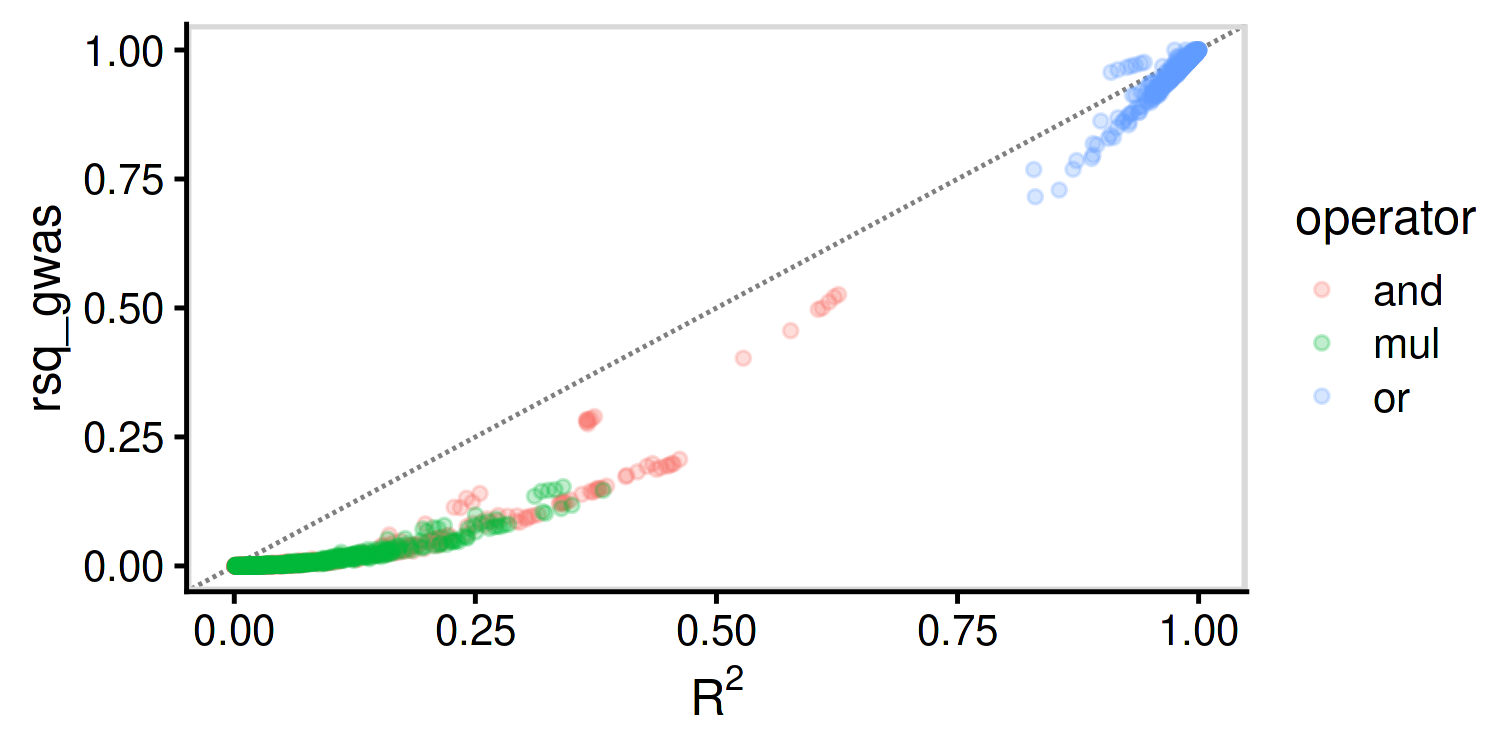

In [17]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 250)

fidelity_vs_fidelity_plot <- plot_df |>
    ggplot(aes(x = rsq_phenotype, y = rsq_gwas, color = operator)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray50") +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    panel_border() +
    xlab(expression(R^2))

fidelity_vs_fidelity_plot